<left>
<table style="margin-top:0px; margin-left:0px;">
<tr>
  <td><img src="https://raw.githubusercontent.com/worm-portal/WORM-Figures/master/style/worm.png" alt="WORM" title="WORM" width=50/></td>
  <td><h1 style=font-size:30px>Water-Rock Reaction Modeling</h1><h2>Introduction to Mass Transfer</h2></td>
</tr>
</table>
</left>

Here is a general example of a water-rock reaction:

$$ \text{rain} + \text{rocks} \rightarrow \text{rivers} + \text{soil} $$

An particularly interesting example of this is called serpentinization. It happens is in places where the Earth's mantle is exposed to the surface and reacts with percolated rainwater. There are only a few places on Earth that we know of where scientists can study serpentinization, but it is thought to be one of the most common geologic processes in the universe.

<div>
<img src="https://raw.githubusercontent.com/worm-portal/WORM-Figures/master/2-Reaction-Properties/4-Univariant-Curves/oman.jpg" width="49%" align="center"/>     <img src="https://raw.githubusercontent.com/worm-portal/WORM-Figures/master/2-Reaction-Properties/4-Univariant-Curves/pigs.jpg" width="49%" align="center"/>
</div>

Image credit: GEOPIG Lab

Left: a "river" produced from serpentinization water-rock reactions in Oman.

Right: a closeup of serpentine minerals with 1 inch-long piggies for scale

<br/>

<div>
<img src="https://www.researchgate.net/publication/358894465/figure/fig1/AS:1136615871262720@1648001749066/Conceptual-diagram-of-the-process-of-serpentinization-in-Oman-Figure-adapted-from-Leong_W640.jpg" width="75%" align="center"/>
</div>

From [Howells et al. 2022](http://dx.doi.org/10.1029/2021JG006317)



Serpentinization refers to an alteration process where minerals in the serpentine group of phyllosilicates replace minerals like olivine and pyroxene that form at high temperatures and pressures.

In this example, a low-temperature, pH 6 aqueous fluid defined in `rainpH6_input.csv` will be speciated and then reacted at ambient conditions with 1 mole of [forsterite](https://www.mindat.org/min-1584.html) (olivine) bit-by-bit until the reaction is complete. This should produce [brucite](https://www.mindat.org/min-820.html) and the serpentine mineral [chrysotile](https://www.mindat.org/min-975.html) and cause the pH of the fluid to dramatically increase until it is hyperalkaline (~pH 10).


<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/f/fb/Olivine-gem7-10a.jpg" width="32%" align="center"/>
<img src="https://upload.wikimedia.org/wikipedia/commons/7/79/Brucite-231242.jpg" width="32%" align="center"/>
<img src="https://upload.wikimedia.org/wikipedia/commons/8/8a/Chrysotile_1.jpg" width="32%" align="center"/>
</div>

Left: forsterite olivine (credit: Rob Lavinsky). Middle: brucite (credit: Rob Lavinsky). Right: chrysotile (credit: Eurico Zimbres).

Many different kinds of data are produced from the calculation that can be visualized with interactive plots. Most of these plots show how mineral masses or fluid compositions change as a function of reaction progress (Xi).

First, let's make a phase diagram in pressure-temperature space that shows what happens when forsterite (Mg$_2$SiO$_4$) is altered to brucite (Mg(OH)$_2$) and chrysotile (Mg$_3$Si$_2$O$_5$(OH)$_4$) by water.
Using the clues above, we can write this balanced reaction:

$$ \mathop{\rm{2 Mg_{2}SiO_{4(cr)}}} \limits_{\text{(forsterite)}} + \rm{3H_{2}O} \rightarrow \mathop{\rm{Mg(OH)_{2(cr)}}} \limits_{\text{(brucite)}} + \mathop{\rm{Mg_{3}Si_{2}O_{5}(OH)_{4(cr)}}} \limits_{\text{(chrysotile)}}$$

This reaction tells us a great deal about the minerals, but nothing about changes in the aqueous solution involved in the alteration process, and gives us no information about the sequence of events during alteration. We actually want to know about all these things.

So, first we'll make a phase diagram...

Load the Python package needed for univariant curves and tell it to use the WORM thermodynamic database.

In [1]:
from pychnosz import *
_ = thermo("WORM")

reset: thermodynamic system initialized
The WORM thermodynamic database has been loaded: 1713 aqueous, 1976 total species


Now we will use the univariant curve option in pyCHNOSZ to generate a P-T phase diagram for the mineral equilibrium reaction...

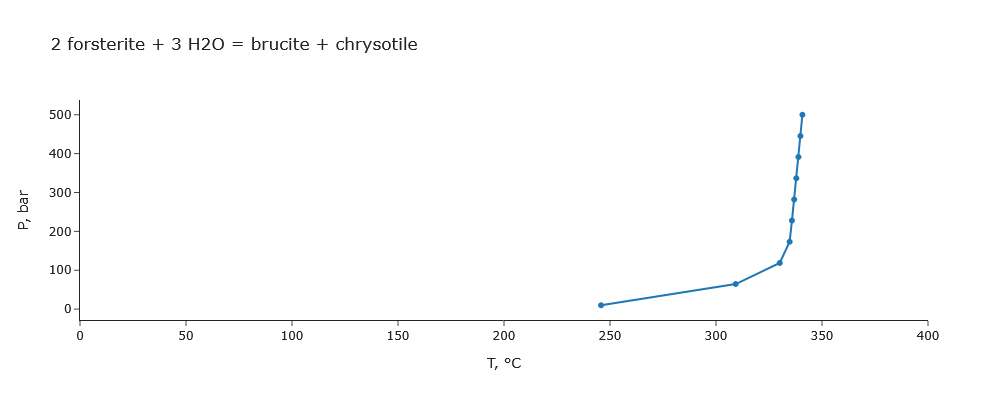

In [2]:
out = univariant_TP(logK=0, # desired logK or list of logK values
                    species=["forsterite","H2O", "brucite","chrysotile"], # chemical species
                    state=["cr", "liq", "cr", "cr"], # aq, gas, liq, cr
                    coeff=[-2, -3, 1, 1], # reaction stoichiometry (negative for reactants, positive for products)
                    Trange=[0, 700], # temperature range to check, degrees C
                    Prange=[10, 500], # pressure range to check, bars
                    xlim=[0, 400], # x axis range
      )

You can practice changing the axes with the plotting tools to make a really nice P-T figure...

Meanwhile, the point is that forsterite + H$_2$O are stable to the high-temperature side of this curve, and brucite + chrysotile are on the low-temperature side. It follows that forsterite being rained on at or near the Earth's surface is not stable relative to brucite and chrysotile!

Now let's do the mass transfer calculation for that alteration process.

Load the Python package.

In [3]:
import aqequil

Load the thermodynamic database and exclude organics to cut down on calculation time.

In [4]:
ae = aqequil.AqEquil(exclude_organics=True)

Loading Water-Organic-Rock-Microbe (WORM) thermodynamic databases...
Excluding ['organic_aq', 'organic_cr'] from column 'category_1'in wrm_data_latest.csv
wrm_data_latest.csv is now set as the active thermodynamic database.
Element database elements.csv is active.
Solid solution database solid_solutions.csv is active.
LogK database wrm_data_logk.csv is active.
Excluding ['organic_aq', 'organic_cr'] from column 'category_1'in wrm_data_logk.csv
LogK_S database wrm_data_logk_s.csv is active.
Excluding ['organic_aq', 'organic_cr'] from column 'category_1'in wrm_data_logk_s.csv
Loading thermodynamic database into pyCHNOSZ...


Speciate the pH 6 fluid defined in `rainpH6_input.csv`.

Antigorite is not a stable serpentine mineral at the conditions of this calculation, so we will ensure its formation is suppressed using the `alter_options` parameter.

In [5]:
speciation = ae.speciate(input_filename="rainpH6_input.csv",
                         alter_options=[["antigorite", "Suppress"]],
                        )

The input file column 'logfO2' will be used to set sample redox state. If a another column is desired, set it manually using the redox_flag parameter.
Getting wrm_data_latest.csv ready. This will take a moment...
No 'charge_balance_on' column found in input file. Defaulting to no charge balancing for all samples.
Using wrm_data_latest.csv to speciate pH6HCl
Finished!


Prepare the reaction by selecting reactant minerals. In this case, we will prepare forsterite to react with the pH 6 fluid.

During early stages of reaction progress forsterite is dissolving into the water.
This means that the dominant reaction is what's called the hydrolysis reaction for forsterite:

$$ \mathop{\rm{2 Mg_{2}SiO_{4(cr)}}} \limits_{\text{(forsterite)}} + \rm{4 H^{+}} \rightarrow \rm{2 Mg^{+2}} + \rm{SiO_{2(aq)}} + \rm{2 H_2O}$$

Therefore our expectation at the early stages is for pH to rise, and the concentrations of total dissolved Mg and Si to increase. But the situation will change if the fluid becomes saturated with a new mineral and we allow it to form!

In [6]:
Forst = aqequil.Reactant(reactant_name="forsterite")

r = aqequil.Prepare_Reaction(reactants=[Forst], write_tab=0)

Run the reaction.

In [7]:
speciation = aqequil.react(speciation, r)

Using wrm_data_latest.csv to react pH6HCl


Select the sample by its name, `pH6HCl`, for analysis and plotting.

In [8]:
m = speciation.mt("pH6HCl")

## Available plot types

Plot pH as a function of reaction progress (Xi)

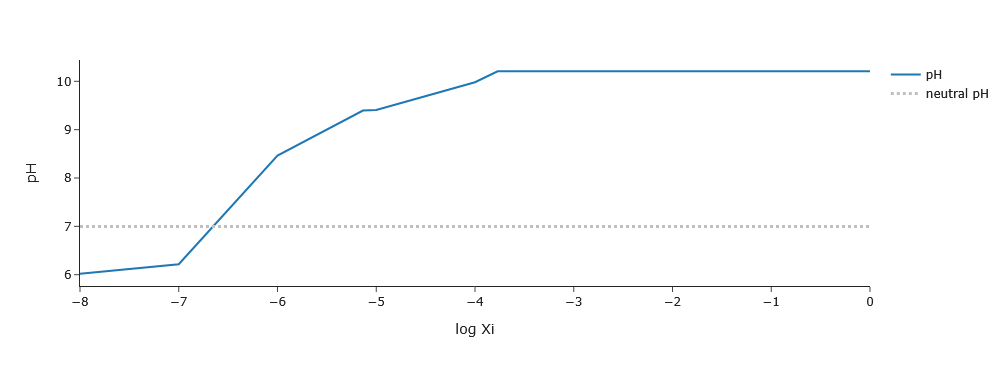

In [9]:
m.plot_pH()

Hey! pH increases as we expected, and it has an elaborate path...

Let's plot concentrations of dissolved elements as functions of reaction progress (Xi)

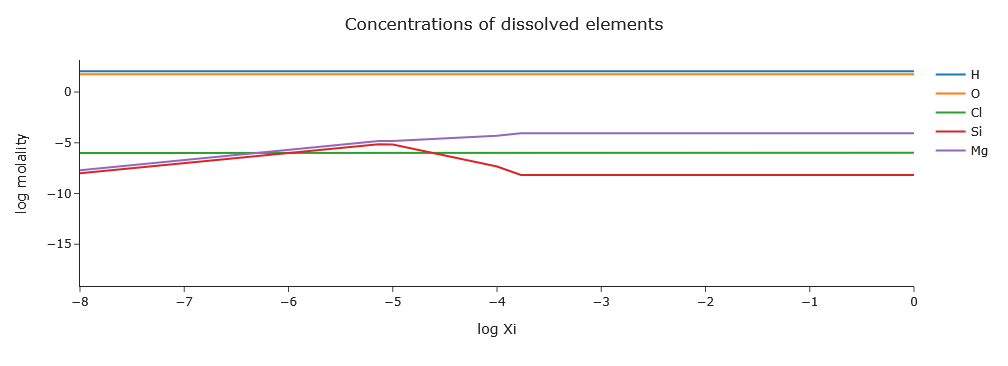

In [10]:
m.plot_elements(log=True)

Ok, the concentration of total dissolved Mg increases. The concentration of total dissolved Si starts to increase as well, but then falls to low concentrations.
You can use the zoom tool to check out the early stages of reaction (up to log Xi = -5 or so). 
Mouse over the points at 10$^{-7}$ and 10$^{-6}$ log Xi and see if the ratio of total Mg to total Si is 2 like the forsterite dissolution (hydrolysis) reaction would have us believe.

Ha! it's true.

It is also true at the maximum point on the Si curve -- check it out!

But right there, at log Xi = -5.134 something happens that causes the total Si curve to change course.
A good guess would be the precipitation from solution of a silicate mineral. Let's see!

Plot the moles of minerals produced as functions of reaction progress (Xi)

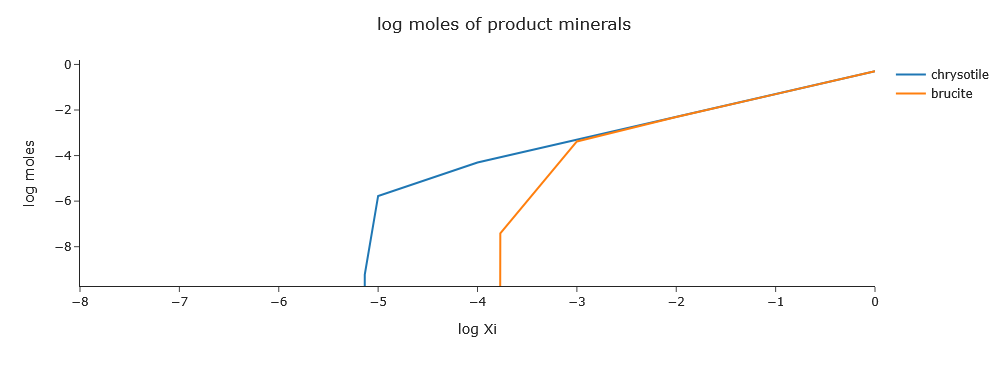

In [11]:
m.plot_product_minerals(show_reactant_minerals=False)

A-ha! Right there at log Xi = -5.134 chrysotile appears as a product. It's the first mineral to appear, but may not be the last in the alteration assemblage.

Comparing the last two plots, we can see that as chrysotile appears the total dissolved Si falls dramatically and the total dissolved Mg skyrockets! What is going on?

First, it may help to remind ourselves about the overall process we're modeling.

Forsterite is dissolving continuously. In fact, the way we keep track of reaction progress (Xi) is by quantifying the amount of forsterite that has dissolved. Mg and Si increase in the 2:1 ratio we expect from the forsterite hydrolysis reaction until the solution reaches saturation with chrysotile at log Xi = -5.134.

Now there is a second reaction involved, chrysotile formation!

$$ \rm{3 Mg^{+2}} + \rm{2 SiO_{2(aq)}} + \rm{5 H_2O} \rightarrow \mathop{\rm{Mg_{3}Si_{2}O_{5}(OH)_{4(cr)}}} \limits_{\text{(chrysotile)}} + \rm{6 H^+}$$

So that second reaction is removing Mg and Si from solution. But it does so in a 3:2 ratio.

And all the while forsterite is dissolving, contributing Mg and Si to solution in a 2:1 ratio.

Examining these ratios will reveal why chrysotile formation drives the total Si concentration down, as forsterite dissolves and chrysotile forms, and the total Mg concentration up: More Mg is being added than is being removed.

Now we can explain why the total Mg concentration climbs. Then, at log Xi = -3.77 the Mg curve goes flat!
Looking at the other plot reveals what changes. This is the point that brucite can form. Precipitation of brucite will remove Mg from solution and maintain the Mg concentration at the equilibrium value.

$$ \rm{Mg^{+2}} + \rm{2 H_2O} \rightarrow \mathop{\rm{Mg(OH)_{2(cr)}}} \limits_{\text{(brucite)}} + \rm{2 H^+} $$

So, while reaction progress increases, and forsterite is dissolving and contributing Mg and Si in a 2:1 ratio, both chrysotile and brucite are forming... and the two curves showing total moles of minerals produced are on top of each other. Equal amounts of chrysotile and brucite are forming. Let's see why...

Brucite and chrysotile forming together means that Mg and Si are removed in a 4:2 ratio, which is the same as the 2:1 ratio that they are being added by forsterite dissolution!

We could anticipate this by writing an overall reaction involving mineral reactants and products like we did above for making the phase diagram for


$$ \mathop{\rm{2 Mg_{2}SiO_{4(cr)}}} \limits_{\text{(forsterite)}} + \rm{3H_{2}O} \rightarrow \mathop{\rm{Mg(OH)_{2(cr)}}} \limits_{\text{(brucite)}} + \mathop{\rm{Mg_{3}Si_{2}O_{5}(OH)_{4(cr)}}} \limits_{\text{(chrysotile)}}$$

but, that overall reaction doesn't reveal anything about what goes on in the coexisiting solution.

It is not that it is wrong, it is just incomplete. Changes are happening to the minerals, and changes also happen to the solution!

We can view these changes simultaneously by following our reaction path on an activity diagram.
Let's start with some basics. 

If we return to the forsterite dissolution reaction:

$$ \mathop{\rm{2 Mg_{2}SiO_{4(cr)}}} \limits_{\text{(forsterite)}} + \rm{4 H^{+}} \rightarrow \rm{2 Mg^{+2}} + \rm{SiO_{2(aq)}} + \rm{2 H_2O}$$

we realize that there are three aqueous solutes involved (Mg$^{+2}$, SiO$_{2(aq)}$, and H$^+$).

Rather than making a three-dimensional diagram to depict the path, we can stay in two dimensions by placing two of our variables in a ratio.
Often the choice is made to do this with the cations as (a$_{\rm{Mg}^{+2}}$)/(a$^{2}_{\rm{H^{+}}}$), where a stands for activity.
then if we plot the log of that activity ratio vs the log activity of SiO$_{2(aq)}$ we can generate an activity diagram.
Let's do that!

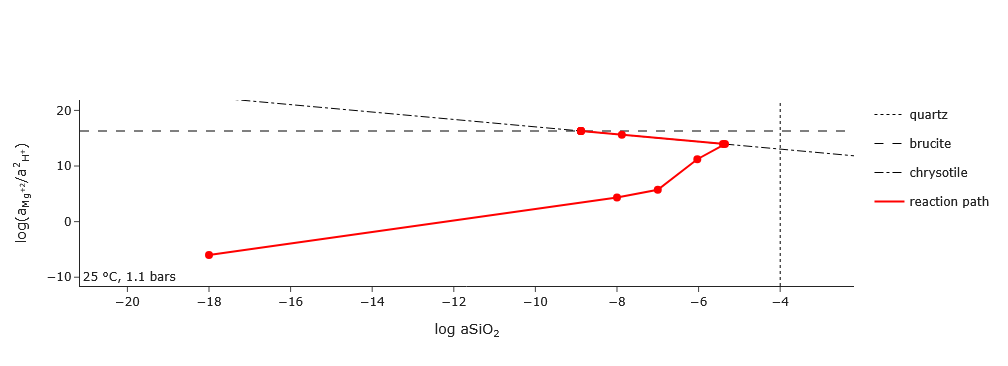

In [12]:
fig_list = m.plot_reaction_paths(flip_xy=True, # flip variables on x and y axes?
                                 colormap="bw", # black and white colormap for the background
                                 minerals_to_show=["quartz"], # show the quartz saturation line for reference
                                 )

_ = [fig.show() for fig in fig_list]

Congratulations! a logarithmic activity diagram is born!

(In this case, log activities of basis species SiO$_{2(aq)}$ and Mg$^{+2}$ are automatically chosen as axis variables because the system only has a limited number of elements. In more complex systems, multiple permutations of plots are shown.)

Once the plot is ready, hover your mouse over the plot to see more.

This plot shows the Mg$^{+2}$ to H$^+$ activity ratio vs the activity of aquoeus silica for our chosen T & P (and remember those are indicated in the .csv file with the initial fluid composition).
The diagram features three dashed lines that show conditions where minerals are stable.
These are called mineral saturation lines. 

Take, for example, the horizontal dashed line labeled brucite in the legend. This line corresponds to equilibrium with respect to the reaction

$$ \rm{Mg^{+2}} + \rm{2 H_2O} \leftrightharpoons \mathop{\rm{Mg(OH)_{2(cr)}}} \limits_{\text{(brucite)}} + \rm{2 H^+} $$

The numerical value of (a$_{\rm{Mg}^{+2}}$)/(a$^{2}_{\rm{H^{+}}}$) can be calculated directly form the equilibrium constant for this reaction. Above this line a solution would be supersaturated with brucite, and precipitation of brucite would help to lower the energy state of the system. Below this line the solution is undersaturated with brucite, and dissolution of brucite (if present) would help to lower the energy state of the system.

The same reasoning produces the saturation lines for quartz and chrysotile, with the same consequences for supersaturation and undersaturation.

The red reaction path shows the results of our mass transfer model. Mouse over the nodes on the path to reveal the corresponding values of Xi.

Note that early on the reaction path starts at low values of log a$_{\rm{SiO}_{2}}$ and log (a$_{\rm{Mg}^{+2}}$)/(a$^{2}_{\rm{H^{+}}}$).

The path is far away from the saturation lines. This is because only a small amount of forsterite has dissolved. As forsterite continues to dissolve the reaction path moves upward and across the diagram. 

This initial trajectory of the path incorporates the changes in pH, Mg, and Si as forsterite dissolves.

Then things change as the fluid reaches equilibrium with chrysotile (check out the value of Xi and see that it is matched in the other figures). Now as forsterite continues to dissolve and chrysotile precipitates the fluid composition moves up and to the left along the chrysotile saturation line. Again, this can be reconciled with the Mg:Si ratios in the dissolveing forsterite and precipitating chrysotile.

The Si content of the fluid decreases as the Mg content of the fluid continues to increase, and the Mg$^{+2}$/H$^+$ activity ratio changes in concert. 

Finally the fluid composition reaches saturation with brucite as well as chrysotile. Brucite joins the fun!

But notice that the fluid composition is stuck at the intersection of the chrysotile and brucite saturation lines. All the Mg and Si being contributed by forsterite dissolution reappear in solid form as brucite and chrysotile. This is, in a way, a disadvantage of the activity diagram if you want to know how much of a new mineral forms. That information is not shown by the activity diagram. Instead you can get that information from the plot showing moles of product minerals. It helps to have all of these various perspectives to fully grasp the transformations that happen to the minerals and to the coexisting aqueous solution.

Now let's find out more about the solutes.

Plot activities of basis aqueous species as functions of reaction progress (Xi)

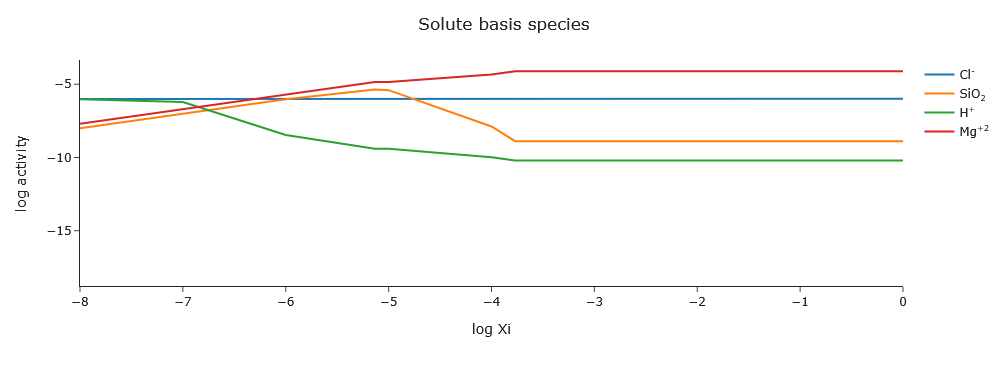

In [13]:
m.plot_aqueous_species(plot_basis=True)

This diagram show us how the activities of the forms of the elements selected as the basis for this calculation (basis species) change in response to reaction progress (Xi). Note the similarities between Mg$^{+2}$ and total Mg plotted above; likewise between SiO$_{2(aq)}$ and total Si.

We can reveal how all the ctivities of all forms of these elements change with reaction progress - remember pH is changing and that could have effects on speciaiton.

Plot activity of basis and non-basis aqueous species as a function of reaction progress (Xi)

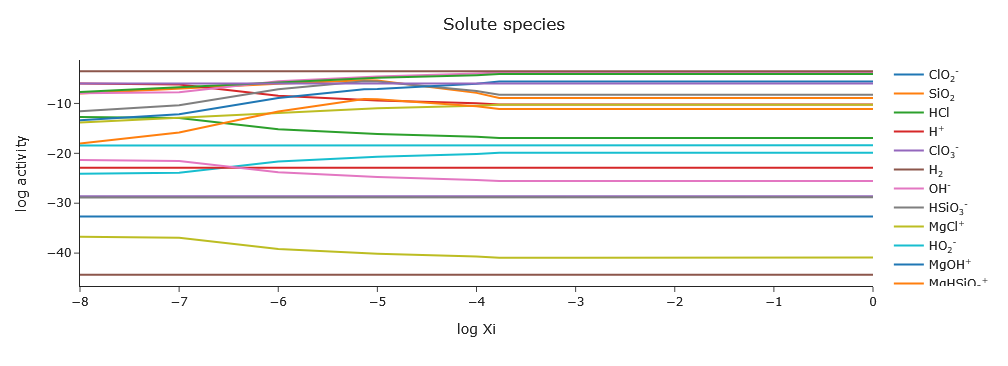

In [14]:
m.plot_aqueous_species(plot_basis=False)

Given all those aqueous species, how does reactions progress affect changes in speciation?
In this case, how does the speciation of aqueous SiO$_{2}$ change with Xi?

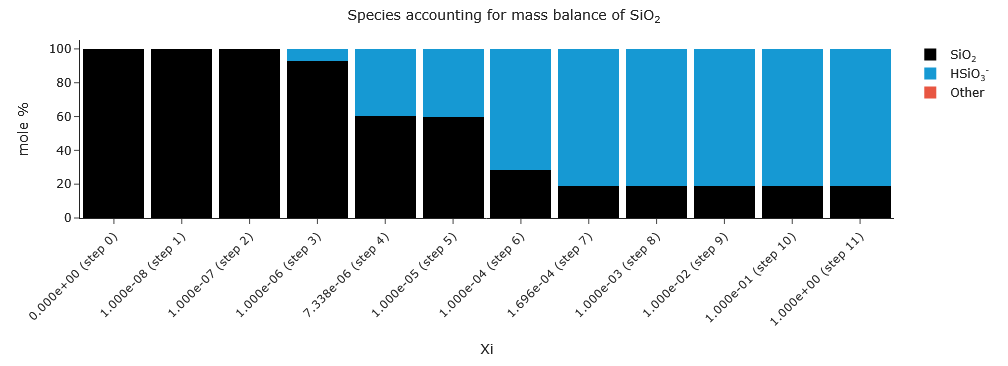

In [15]:
m.plot_mass_contribution("SiO2")

## Tables

Print a list of available tables.

In [16]:
m.print_tabs()

Table B1 Miscellaneous parameters I
Table B2 Miscellaneous parameters II
Table C1 Dissolved elements(molality)
Table C2 Dissolved elements(ppm: mg/kg.sol)
Table C3 Dissolved elements(molarity)
Table C4 Dissolved elements(ppm: mg/L)
Table D1 Solute basis species(total molality)
Table D2 Solute basis species(total ppm: mg/kg.sol)
Table D3 Solute basis species(total molarity)
Table D4 Solute basis species(total ppm: mg/L)
Table E1 Basis species(log true molality; log mole fraction for H2O  log fugacity for O2(g))
Table E2 Basis species(log activity; log fugacity for O2(g))
Table E3 Basis species(log activity coefficient)
Table J Moles of reactants destroyed/created
Table K Affinities of reactants (kcal)
Table P Moles of product minerals
Table Q Saturation indices of potential product phases
Table T Fugacities (bars)
Table W Overall mass and volume changes


Display Table P by copy-pasting its full name from the list above

In [17]:
m.tab["Table P Moles of product minerals"]

,Xi,t(days),chrysotile,brucite
0,0.000,0.000,None,None
1,1.0000E-08,0.000,None,None
2,1.0000E-07,0.000,None,None
3,1.0000E-06,0.000,None,None
4,7.3378E-06,0.000,5.8951E-10,None
5,1.0000E-05,0.000,1.6879E-06,None
6,1.0000E-04,0.000,4.9977E-05,None
7,1.6963E-04,0.000,8.4811E-05,3.8599E-08
8,1.0000E-03,0.000,5.0000E-04,4.1523E-04
9,1.0000E-02,0.000,5.0000E-03,4.9152E-03


Display Table D1 in the same way

In [18]:
m.tab["Table D1 Solute basis species(total molality)"]

,Xi,t(days),H+,Mg+2,Cl-,SiO2
0,0.000,0.000,9.9105E-07,1.0000E-18,1.0000E-06,1.0000E-18
1,1.0000E-08,0.000,9.5105E-07,2.0000E-08,1.0000E-06,1.0000E-08
2,1.0000E-07,0.000,5.9105E-07,2.0000E-07,1.0000E-06,1.0000E-07
3,1.0000E-06,0.000,-3.0089E-06,2.0000E-06,1.0000E-06,1.0000E-06
4,7.3378E-06,0.000,-2.8357E-05,1.4674E-05,1.0000E-06,7.3366E-06
5,1.0000E-05,0.000,-2.8882E-05,1.4936E-05,1.0000E-06,6.6243E-06
6,1.0000E-04,0.000,-9.9148E-05,5.0070E-05,1.0000E-06,4.6368E-08
7,1.6963E-04,0.000,-1.6858E-04,8.4787E-05,1.0000E-06,6.8773E-09
8,1.0000E-03,0.000,-1.6858E-04,8.4787E-05,1.0000E-06,6.8773E-09
9,1.0000E-02,0.000,-1.6858E-04,8.4787E-05,1.0003E-06,6.8773E-09


Display a table of the log activity of aqueous species at different values of Xi. The `.head()` means only the first five rows are displayed in the notebook.

In [19]:
m.aq_distribution_logact.head()

,Xi,ClO2-,SiO2,HCl,H+,ClO3-,H2,OH-,HSiO3-,MgCl+,...,MgOH+,MgHSiO3+,Mg+2,ClO-,Cl-,O2,HClO,ClO4-,HClO2,H2O2
0,0.000000e+00,-32.6765,-18.0001,-12.7107,-6.0000,-28.6131,-44.3227,-7.9950,-21.5854,-24.1375,...,-23.6845,-38.3274,-18.0020,-22.8858,-6.0005,-3.5679,-21.3359,-28.8453,-36.6974,-18.4091
1,1.000000e-08,-32.6765,-8.0001,-12.7282,-6.0175,-28.6131,-44.3227,-7.9775,-11.5679,-13.8365,...,-13.3660,-18.0088,-7.7010,-22.8858,-6.0005,-3.5679,-21.3534,-28.8453,-36.7149,-18.4091
2,1.000000e-07,-32.6765,-7.0002,-12.9276,-6.2168,-28.6132,-44.3227,-7.7782,-10.3687,-12.8367,...,-12.1669,-15.8098,-6.7012,-22.8858,-6.0006,-3.5679,-21.5527,-28.8453,-36.9142,-18.4091
3,1.000000e-06,-32.6772,-6.0316,-15.1737,-8.4622,-28.6139,-44.3227,-5.5328,-7.1547,-11.8404,...,-8.9245,-11.5988,-5.7042,-22.8865,-6.0012,-3.5679,-23.7989,-28.8460,-39.1603,-18.4091
4,7.337800e-06,-32.6793,-5.3526,-16.1098,-9.3963,-28.6160,-44.3227,-4.5987,-5.5416,-10.9873,...,-7.1352,-9.1305,-4.8490,-22.8886,-6.0034,-3.5679,-24.7350,-28.8481,-40.0965,-18.4091


Documentation is available for any function by including `?` at the end of the function name. For instance, here is the documentation for the `AqEquil.Reactant` function used earlier in the notebook to define forsterite and fayalite as minerals to react with speciated fluids:

In [20]:
aqequil.Reactant?

Init signature:
aqequil.Reactant(
    reactant_name,
    reactant_type='Pure mineral',
    reactant_status='Reacting',
    amount_remaining=1,
    amount_destroyed=0,
    molar_volume=0,
    surface_area_option=0,
    surface_area_value=0,
    surface_area_factor=0,
    f_rate_law='Relative rate equation',
    f_eq1=1,
    f_eq2=0,
    f_eq3=0,
    b_rate_law='Partial equilibrium',
    b_eq1=1,
    b_eq2=0,
    b_eq3=0,
    special_reactant_dict={},
    hide_traceback=True,
)
Docstring:      <no docstring>
Init docstring:
Class used to define reactants for `Prepare_Reaction`.

Parameters
----------
reactant_name : str
    Name of the reactant.

reactant_type : str, default "Pure mineral"
    Reactant type. Valid types include:
    
    - Pure mineral
    - Solid solution
    - Special reactant
    - Aqueous species
    - Gas species
    - Generic ion exchanger

reactant_status : str, default "Reacting"
    Status of the reactant. Valid statuses include:
    
    - Reacting
    - Satura

End of Demo.